<h2> (1) Import all relevant libraries, layer and classes <h2>


In [1]:
# General
import os
import time

# Python libraries
import numpy as np, collections
import pydot as pyd
import matplotlib.pyplot as plt
from IPython.display import SVG

# Tensorflow
import tensorflow as tf

# Keras
import keras.backend as k
from keras import optimizers
from keras import losses, regularizers
from keras import initializers
from keras.utils import plot_model, to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier

# CoreML 
import coremltools
import tfcoreml as tf_converter

# Scikit-learn
from sklearn import metrics
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, GridSearchCV

# Seaborn
import seaborn as sn

# Locale methods and properties
from auxilary_functions import time_stamp
from load_data import load_and_store_data, load_stored_data 
from model import create_compiled_model
from callbacks import get_callbacks 
from plot_pose_sequence import plot_trainings_data, plot_test_data
from plot_confusion_matrix import print_confusion_matrix 
from plot_trainings_history import plot_loss_acc
from plot_data_distribution import plot_data_distribution

Using TensorFlow backend.
W0719 00:25:35.784710 140073184642880 __init__.py:71] TensorFlow version 1.14.0 detected. Last version known to be fully compatible is 1.13.1 .


<h2> (2) Load and prepare goalkeeper pose data <h2>

In [2]:
DATA_PATH = "./stored_data/"

# Load data from .npy files 
# (Framrates/Poses-per-sequence: '5' / '10' / '15' / '30' / '45' / '60' / '75' / '90')
X, y = load_stored_data(dir_path=DATA_PATH, num_poses='90')
# X = [samples, timesteps, features]
# y = [samples, labels]

# Split dataset into train and test set (and shuffle them)
X_train, X_test, y_train_temp, y_test_temp = train_test_split(X, y, test_size = 0.1, random_state = 42)

# Get one hot vector from labels
y_train = to_categorical(y_train_temp, num_classes=6)
y_test = to_categorical(y_test_temp, num_classes=6)

# Input features
INPUT = [
    "HEAD_X",
    "HEAD_Y_",
    "BODY_X",
    "BODY_Y",
    "LEFT_ARM_X",
    "LEFT_ARM_Y",
    "RIGHT_ARM_X",
    "RIGHT_ARM_Y",
    "LEFT_LEG_X",
    "LEFT_LEG_Y",
    "RIGHT_LEG_X",
    "RIGHT_LEG_Y",
]

# Output classes
LABELS = [    
    "STAND_BY",
    "LEFT_DIVE",
    "LONG_LEFT_DIVE",
    "RIGHT_DIVE",
    "LONG_RIGHT_DIVE",
    "HIGH_CATCH",
]

# Some debugging info
print("---------------------------------------")
print("---------------------------------------")
print("Bsic information regardin the data:")
print("---------------------------------------")
print("Trainings data...")
print("... input shape=" + str(X_train.shape))
print("... target shape=" + str(y_train.shape))
print("---------------------------------------")
print("Test data...")
print("... input shape=" + str(X_test.shape))
print("... target shape=" + str(y_test.shape))
print("---------------------------------------")
print("---------------------------------------")

---------------------------------------
---------------------------------------
Bsic information regardin the data:
---------------------------------------
Trainings data...
... input shape=(1194, 90, 26)
... target shape=(1194, 6)
---------------------------------------
Test data...
... input shape=(133, 90, 26)
... target shape=(133, 6)
---------------------------------------
---------------------------------------


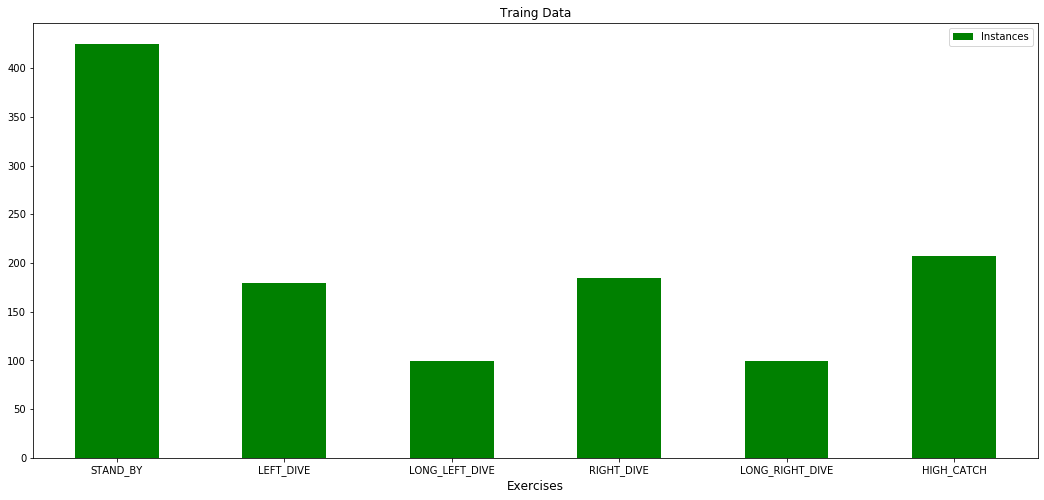

In [3]:
# Plot data distribution (trainings data)
plot_data_distribution(y_train_temp, labels=LABELS)

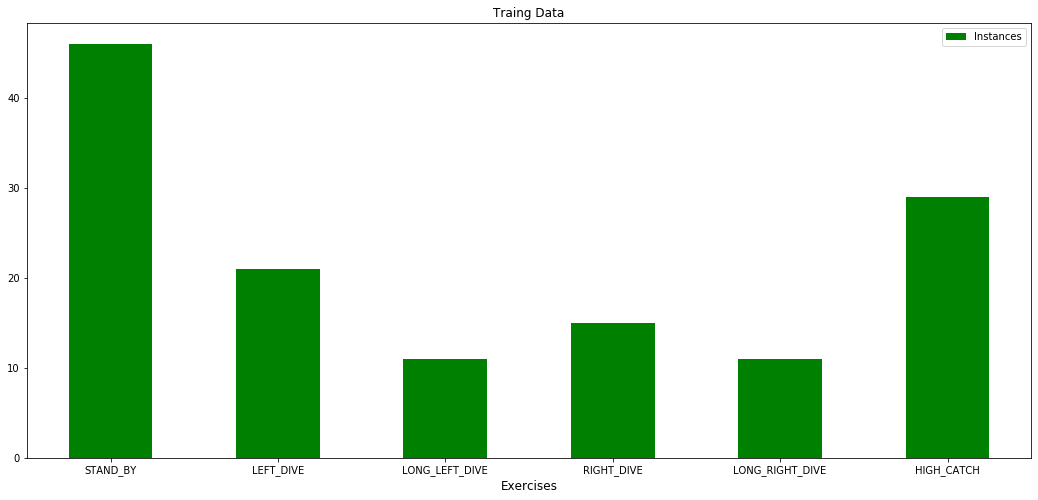

In [4]:
# Plot data distribution (teest data)
plot_data_distribution(y_test_temp, labels=LABELS)

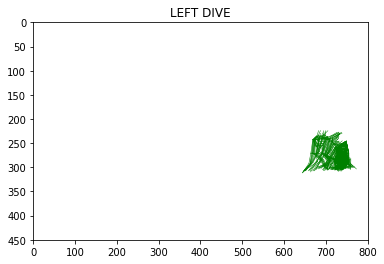

In [ ]:
# Plot one sequence of poses
plot_trainings_data(X_train, y_train_temp, sample=25)

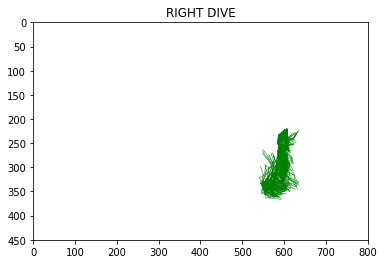

In [ ]:
# Plot one sequence of poses
plot_trainings_data(X_train, y_train_temp, sample=845)

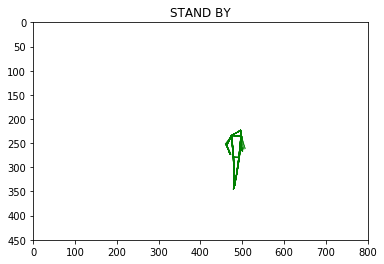

In [ ]:
# Plot one sequence of poses
plot_trainings_data(X_train, y_train_temp, sample=103)

<h2> (3) Define constants and additional parameters <h2>

In [ ]:
# Input Data
n_timesteps = X_train.shape[1] #len(X_train[1])  # n-timesteps per series per series
n_features = X_train.shape[2] #len(X_train[0][0])  # n input parameters per timestep

# LSTM Neural Network's internal structure
input_shape = (n_timesteps, n_features)
n_mem_units = 180 # Hidden layer num of features
n_classes = len(LABELS) # n classes (should go up, or should go down)

# Training - Hyperparameter  
learning_rate = 0.001
init = ['glorot_uniform', 'normal', 'uniform']
optimizers = [optimizers.RMSprop(lr=learning_rate, decay=0.5), 
              optimizers.Adam(lr=learning_rate, decay=0.5) ]
num_epochs = np.array([5, 10, 15])
batch_size = np.array([587])

<h2> (4) Define and build sequence model <h2>

In [ ]:
# Create model
model = KerasClassifier(build_fn=create_compiled_model, input_shape=input_shape)

# Create Parameter Grid 
param_grid = {'init':init, 'optimizer':optimizers, 'epochs':num_epochs, 'batch_size':batch_size}

# Generate Grid Search Model with above parameters
grid_search = GridSearchCV(estimator=model, param_grid=param_grid)

# Get curent time stamp
time_stamp = time_stamp()

<h2> (5) Record and store process of models/training <h2>

In [ ]:
# Tensorboard
logdir = './training_history/logs/' + time_stamp

# Create directory which will contain trained models 
model_directory = "./training_history/saved_models/" + time_stamp

# Generate callback list 
callbacks = get_callbacks(model_directory, logdir, time_stamp)

<h2> (6) Train model <h2>

In [ ]:
# Weight classes to overcome the unbalanced data
#class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_temp), y_train_temp)

# Reshape model fo CoreML model 
reshaped_X_train = X_train.reshape(X_train.shape[0],-1)

# Train model on trainings data 
grid_result = grid_search.fit(reshaped_X_train, y_train)

/home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
W0719 00:25:44.100024 140073184642880 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 00:25:44.101401 140073184642880 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 00:25:44.113297 140073184642880 deprecation_wrapper.py:119] From /home/sami/anaconda3/envs/tf/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Pl

Epoch 1/5
796/796 [==============================] - 7s 9ms/step - loss: 2.0254 - mean_squared_error: 0.1530 - acc: 0.1658
Epoch 2/5
796/796 [==============================] - 3s 4ms/step - loss: 1.5898 - mean_squared_error: 0.1285 - acc: 0.3028
Epoch 3/5
796/796 [==============================] - 3s 4ms/step - loss: 1.2572 - mean_squared_error: 0.1032 - acc: 0.5590
Epoch 4/5
796/796 [==============================] - 3s 4ms/step - loss: 1.1465 - mean_squared_error: 0.0949 - acc: 0.5917
Epoch 5/5
398/398 [==============================] - 1s 3ms/step
Epoch 1/5
796/796 [==============================] - 7s 9ms/step - loss: 2.0023 - mean_squared_error: 0.1473 - acc: 0.2098
Epoch 2/5
796/796 [==============================] - 3s 4ms/step - loss: 1.5925 - mean_squared_error: 0.1222 - acc: 0.4121
Epoch 3/5
796/796 [==============================] - 3s 4ms/step - loss: 1.4253 - mean_squared_error: 0.1123 - acc: 0.5050
Epoch 4/5
796/796 [==============================] - 3s 4ms/step - loss: 1

796/796 [==============================] - 3s 4ms/step - loss: 1.7510 - mean_squared_error: 0.1356 - acc: 0.2877
Epoch 3/5
796/796 [==============================] - 4s 5ms/step - loss: 1.6395 - mean_squared_error: 0.1291 - acc: 0.3505
Epoch 4/5
796/796 [==============================] - 3s 4ms/step - loss: 1.5658 - mean_squared_error: 0.1245 - acc: 0.3794
Epoch 5/5
398/398 [==============================] - 3s 8ms/step
Epoch 1/5
796/796 [==============================] - 13s 16ms/step - loss: 1.7792 - mean_squared_error: 0.1384 - acc: 0.1947
Epoch 2/5
796/796 [==============================] - 3s 4ms/step - loss: 1.6409 - mean_squared_error: 0.1296 - acc: 0.3392
Epoch 3/5
796/796 [==============================] - 3s 4ms/step - loss: 1.5729 - mean_squared_error: 0.1251 - acc: 0.3894
Epoch 4/5
796/796 [==============================] - 3s 4ms/step - loss: 1.5290 - mean_squared_error: 0.1220 - acc: 0.4133
Epoch 5/5
398/398 [==============================] - 3s 9ms/step
Epoch 1/5
796/796

796/796 [==============================] - 4s 5ms/step - loss: 1.8571 - mean_squared_error: 0.1408 - acc: 0.2198
Epoch 5/10
796/796 [==============================] - 3s 4ms/step - loss: 1.8076 - mean_squared_error: 0.1382 - acc: 0.2437
Epoch 6/10
796/796 [==============================] - 3s 4ms/step - loss: 1.7623 - mean_squared_error: 0.1357 - acc: 0.3178
Epoch 7/10
796/796 [==============================] - 4s 4ms/step - loss: 1.7223 - mean_squared_error: 0.1334 - acc: 0.3266
Epoch 8/10
796/796 [==============================] - 3s 4ms/step - loss: 1.6845 - mean_squared_error: 0.1312 - acc: 0.3367
Epoch 9/10
796/796 [==============================] - 3s 4ms/step - loss: 1.6503 - mean_squared_error: 0.1292 - acc: 0.3492
Epoch 10/10
398/398 [==============================] - 4s 11ms/step
Epoch 1/10
796/796 [==============================] - 17s 21ms/step - loss: 1.9390 - mean_squared_error: 0.1492 - acc: 0.2173
Epoch 2/10
796/796 [==============================] - 3s 4ms/step - loss:

796/796 [==============================] - 3s 4ms/step - loss: 1.7007 - mean_squared_error: 0.1327 - acc: 0.3317
Epoch 8/10
796/796 [==============================] - 4s 5ms/step - loss: 1.6521 - mean_squared_error: 0.1300 - acc: 0.3442
Epoch 9/10
796/796 [==============================] - 3s 4ms/step - loss: 1.6076 - mean_squared_error: 0.1277 - acc: 0.3618
Epoch 10/10
398/398 [==============================] - 5s 13ms/step
Epoch 1/10
796/796 [==============================] - 19s 24ms/step - loss: 2.1064 - mean_squared_error: 0.1581 - acc: 0.1947
Epoch 2/10
796/796 [==============================] - 3s 4ms/step - loss: 2.0487 - mean_squared_error: 0.1552 - acc: 0.2048
Epoch 3/10
796/796 [==============================] - 4s 4ms/step - loss: 1.9810 - mean_squared_error: 0.1516 - acc: 0.2161
Epoch 4/10
796/796 [==============================] - 4s 5ms/step - loss: 1.9061 - mean_squared_error: 0.1473 - acc: 0.2211
Epoch 5/10
796/796 [==============================] - 3s 4ms/step - loss:

In [ ]:
print("train score - " + str(grid_search.score(reshaped_X_train, y_train)))
print("test score - " + str(grid_search.score(reshaped_X_train, y_test)))

<h2> (7) Predict and evaluate <h2>

In [ ]:
# Show the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
cv_result = pd.DataFrame(grid_search.cv_results_)
cv_result.sort_values('rank_test_score')